In [1]:
import pandas as pd
import numpy as np

dataset_path = 'db_nl_iterative.csv'

df = pd.read_csv(dataset_path)
df_showcase = pd.read_csv('db_subset.csv')
df[np.isnan(df)] = 0
features = [c for c in df.columns]
X = np.array(df[features])

In [2]:
import kmapper as km
from sklearn import ensemble, cluster


# y = np.array(df.target)
projector = ensemble.IsolationForest(random_state=0, n_jobs=-1)
projector.fit(X)

lens1 = projector.decision_function(X)

mapper = km.KeplerMapper(verbose=3)
lens2 = mapper.fit_transform(X, projection="knn_distance_5")

lens = np.c_[lens1, lens2]

KeplerMapper(verbose=3)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (2885, 86)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()



In [3]:
G = mapper.map(
    lens,
    X,
    cover = km.Cover(n_cubes=20,
                     perc_overlap=.7),
    clusterer=cluster.AgglomerativeClustering(3))

print(f"num nodes: {len(G['nodes'])}")
print(f"num edges: {sum([len(values) for key, values in G['links'].items()])}")

Mapping on data shaped (2885, 86) using lens shaped (2885, 2)

Minimal points in hypercube before clustering: 3
Creating 400 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

Cube_9 is empty.

Cube_10 is empty.

Cube_11 is empty.

Cube_12 is empty.

   > Found 3 clusters in hypercube 13.
   > Found 3 clusters in hypercube 14.
   > Found 3 clusters in hypercube 15.
   > Found 3 clusters in hypercube 16.
Cube_17 is empty.

Cube_18 is empty.

Cube_19 is empty.

   > Found 3 clusters in hypercube 20.
   > Found 3 clusters in hypercube 21.
   > Found 3 clusters in hypercube 22.
   > Found 3 clusters in hypercube 23.
Cube_24 is empty.

Cube_25 is empty.

Cube_26 is empty.

Cube_27 is empty.

Cube_28 is empty.

Cube_29 is empty.

   > Found 3 clusters in hypercube 30.
   > Found 3 clusters in hypercube 31.
   > Found 3 clusters in hypercube 32.
   > Found 3 clusters in h

In [4]:
_ = mapper.visualize(
    G,
    #custom_tooltips=y,
    # color_values=y,
    # color_function_name="target",
    path_html="tor-tda-median-20.html",
    # X=X,
    # X_names=list(df[features].columns),
    # lens=lens,
    # lens_names=["IsolationForest", "KNN-distance 5"],
    # title="Detecting encrypted Tor Traffic with Isolation Forest and Nearest Neighbor Distance",
    #style=style,
    # custom_tooltips=np.array([f"Node {i}" for i in range(len(y))])
)

Wrote visualization to: tor-tda-median-20.html


In [5]:
import csv

with open('mapper_graph_adjacency_list.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['source', 'target']) 
    
    for source, targets in G['links'].items():
        for target in targets:
            writer.writerow([source, target])


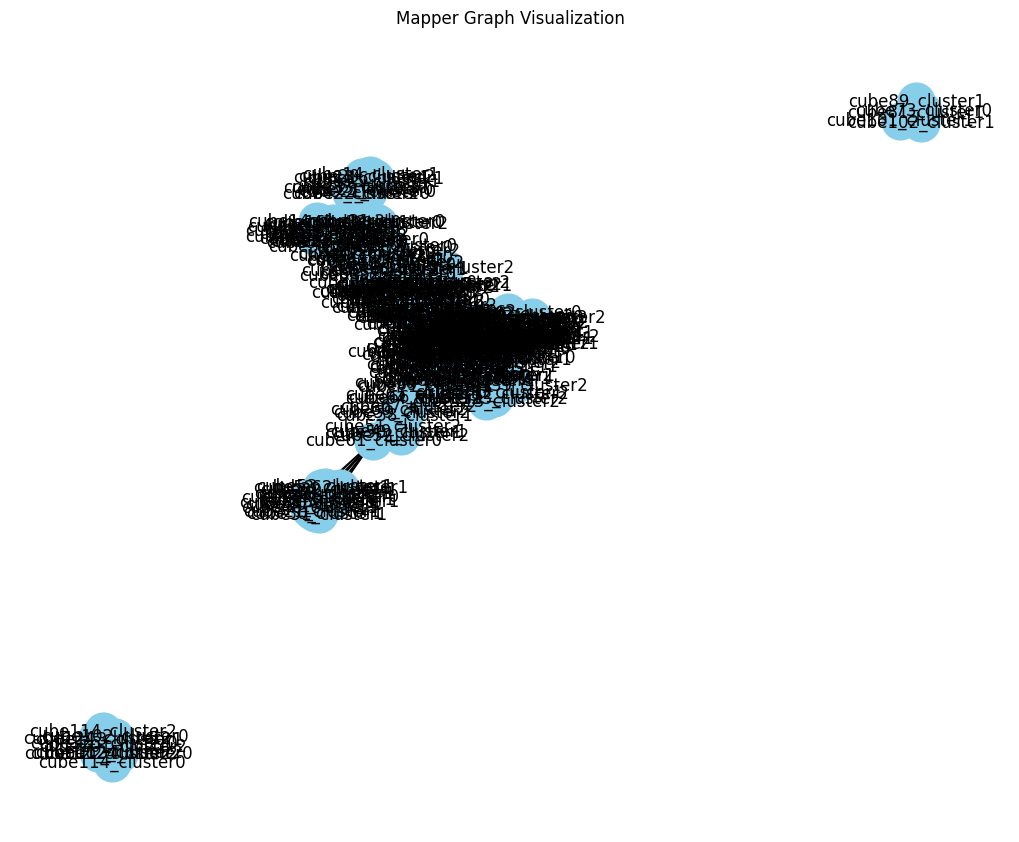

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

G_nx = nx.Graph()

with open('mapper_graph_adjacency_list.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader, None) 
    for row in reader:
        G_nx.add_edge(row[0], row[1])

plt.figure(figsize=(10, 8))
nx.draw(G_nx, with_labels=True, node_color='skyblue', node_size=700, edge_color='k')
plt.title("Mapper Graph Visualization")
plt.show()

In [7]:
with open('nodes_to_rows.csv', 'w', newline='') as csvfile:
    fieldnames = ['node_id', 'row_indices']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for node_id, members in G['nodes'].items():
        row_indices_str = ','.join(map(str, members))
        writer.writerow({'node_id': node_id, 'row_indices': row_indices_str})

In [8]:
import pandas as pd
import dash
from dash import dcc, html
import plotly.graph_objects as go

df = pd.read_csv('df_median (1).csv') 


nodes_to_rows = pd.read_csv('nodes_to_rows.csv')
#nodes_to_rows['row_indices'] = nodes_to_rows['row_indices'].apply(eval) 
nodes_to_rows['row_indices'] = nodes_to_rows['row_indices'].apply(lambda x: [int(i) for i in x.split(',')])

node_counts = nodes_to_rows['row_indices'].apply(len)

app = dash.Dash(__name__)

fig = go.Figure(data=[
    go.Bar(x=nodes_to_rows['node_id'], y=node_counts, marker_color='blue')
])
fig.update_layout(title='Количество строк на ноду в графе Mapper', xaxis_title='Node ID', yaxis_title='Количество строк')

app.layout = html.Div([
    html.H1('Интерактивный дашборд для анализа графа Mapper'),
    dcc.Graph(figure=fig),
    # Здесь можно добавить дополнительные компоненты Dash для отображения другой полезной информации
])

if __name__ == '__main__':
    app.run_server(debug=True)

In [9]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)  

nodes_data_path = 'nodes_to_rows.csv'
nodes_data = pd.read_csv(nodes_data_path)

dataset_path = 'df_median (1).csv'
original_dataset = pd.read_csv(dataset_path)

def show_rows(node_id):
    rows_str = nodes_data.loc[nodes_data['node_id'] == node_id, 'row_indices'].values[0]
    rows_list = list(map(int, rows_str.split(',')))
    selected_rows = original_dataset.iloc[rows_list]
    clear_output(wait=True)
    #display(node_id_selector)
    display(selected_rows)

node_id_selector = widgets.Dropdown(
    options=nodes_data['node_id'].unique(),
    description='Node ID:',
    disabled=False,
)

interactive_widget = widgets.interactive(show_rows, node_id=node_id_selector)

display(interactive_widget)

interactive(children=(Dropdown(description='Node ID:', options=('cube13_cluster0', 'cube13_cluster1', 'cube13_…

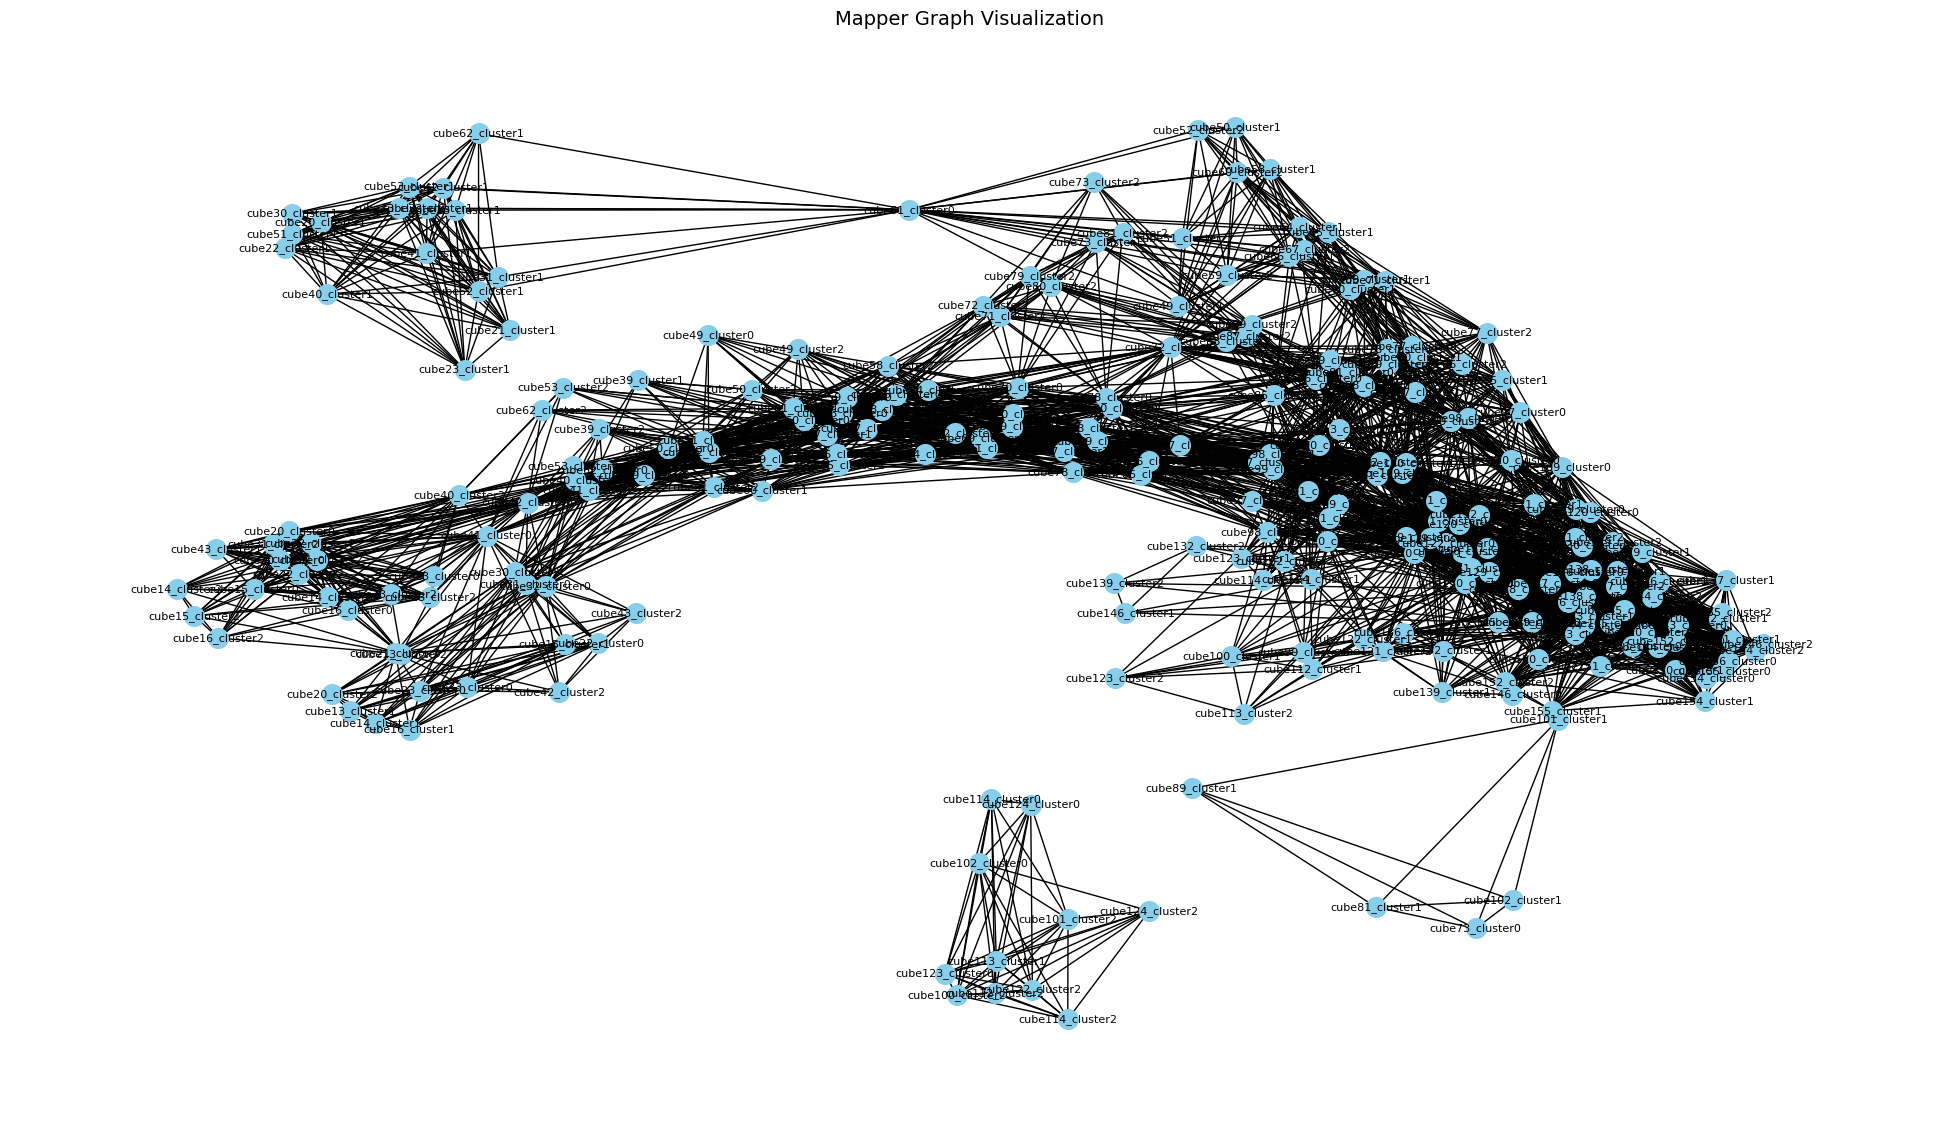

In [35]:
import networkx as nx
import matplotlib.pyplot as plt
import csv

G_nx = nx.Graph()

with open('mapper_graph_adjacency_list.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader, None) 
    for row in reader:
        G_nx.add_edge(row[0], row[1])

plt.figure(figsize=(19.20, 10.80))
pos = nx.spring_layout(G_nx, k=3, iterations=500, weight=0, fixed=None, center=(0, 0), scale=5000, dim=2)

nx.draw(G_nx, pos,
        with_labels=True, 
        font_size=8, 
        node_color='skyblue', 
        node_size=200,  
        edge_color='k')

plt.title("Mapper Graph Visualization", fontsize=14)  
plt.savefig('mapper_graph_visualization.png', format='png', dpi=100)  # Указываем DPI, соответствующее размерам в дюймах
plt.show()


In [36]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

nodes_data_path = 'nodes_to_rows.csv'
nodes_data = pd.read_csv(nodes_data_path)

dataset_path = 'df_mular_median (1).csv'
# dataset_path
original_dataset = pd.read_csv(dataset_path)

def show_rows(node_ids):
    # Собираем индексы строк из всех выбранных узлов
    all_rows_list = []
    for node_id in node_ids:
        rows_str = nodes_data.loc[nodes_data['node_id'] == node_id, 'row_indices'].values[0]
        rows_list = list(map(int, rows_str.split(',')))
        all_rows_list.extend(rows_list)
    
    # Удаляем дубликаты индексов, если они есть
    unique_rows_list = list(set(all_rows_list))
    
    # Выбираем уникальные строки из оригинального датасета
    selected_rows = original_dataset.iloc[unique_rows_list]
    clear_output(wait=True)
    #display(node_id_selector)
    display(selected_rows)

# Виджет для множественного выбора
node_id_selector = widgets.SelectMultiple(
    options=nodes_data['node_id'].unique(),
    description='Node IDs:',
    disabled=False,
    layout=widgets.Layout(width='300px', height='300px')  # Задайте нужные размеры здесь
)

interactive_widget = widgets.interactive(show_rows, node_ids=node_id_selector)

display(interactive_widget)


interactive(children=(SelectMultiple(description='Node IDs:', layout=Layout(height='300px', width='300px'), op…